# Homework 4 Exercise 1

Brennan McFarland
bfm21

In this excercise we attempt to apply the Expectation-Maximization algorithm to adapt the means of a 2D Gaussian Mixture Model with fixed covariance matrices.

In [1]:
import csv, copy, gzip, pickle

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import chi2

%matplotlib inline

## Deriving the EM Equations

We can derive the equations for the Expectation-Maximization algorithm by starting with the multivariate Gaussian distribution:  
$p(x|\mu,\sum) = N(x|\mu,\sum) = \frac{exp(-\frac{1}{2}(x-\mu)^{T}\sum^{-1}(x-\mu))}{(2\pi)^{D/2}|\sum|^{\frac{1}{2}}}$  
and taking its log:  
$ln(p(x|\mu,\sum)) = -\frac{1}{2}ln(2\pi)-\frac{1}{2}ln|\sum|-\frac{1}{2}(x-\mu)^{T}\sum^{-1}(x-\mu)$  
We can then take the derivative of this log with respect to the parameters $\mu$ and $\sum$ and set them to 0 to get their maximum values:  
$\frac{d(ln(p(x|\mu,\sum)))}{d\mu} = 0 \rightarrow \mu_{k} = \sum_{n} p_{n,k}x^{(n)}/p_{k}$  
$\frac{d(ln(p(x|\mu,\sum)))}{d\sum} = 0 \rightarrow \sum_{k} = \sum_{n} p_{n,k}(x^{(n)}-\mu_{k})(x^{(n)}-\mu_{k})^{T}/p_{k}$  
This gives us our first two equations from the M-step.  The remaining equations follow directly from the model.

And so we arrive at our final EM Equations:  
E-step: We compute $p_{n,k}$ and $p_k$:  
$p_{n,k} = p(c_{k}|x^{(n)},\theta_{1:K})$  
$p_k = \sum_{n}p_{n,k}$  
M-step: For each class, we compute the updated mean $\mu_{k}$, covariance $\sum_{k}$, and class prior $p(c_{k})$:  
$\mu_{k} = \sum_{n} p_{n,k}x^{(n)}/p_{k}$  
$\sum_{k} = \sum_{n} p_{n,k}(x^{(n)}-\mu_{k})(x^{(n)}-\mu_{k})^{T}/p_{k}$  
$p(c_{k}) = p_{k}$

## Loading the Data

We can load the Yellowstone faithful geyser data from the class example to demonstrate the algorithm:

In [2]:
with open('data/faithful.txt', 'rt') as csvfile:
    dataReader = csv.reader(csvfile, delimiter=' ')
    # initialize an empty array
    data = []
    for row in dataReader:
        data.append(np.array(row).astype(np.float))
    # convert data into a numpy array
    data = np.asarray(data)

## Initializing the Mixture Model

We can initialize the mixture model with starting means ($\mu$, mu) and covariance matrices ($\sum$, sigma) and check to make sure the latter's values are legal:

In [3]:
ngmm = 2 # quantity of Gaussian Mixture Model
mu = np.asarray([[2, 70], 
                 [4, 80]]
               ).astype('float')

sigma = np.asarray([[[1, 0], 
                     [0, 3]], 
                    [[0.5, 0.2], 
                     [0.2, 0.6]]]
                  ).astype('float')
def covmatIsLegal(sigma):
    for covmat in sigma:
        if not(np.allclose(covmat, covmat.T)) or np.any(np.linalg.eigvals(covmat) <= 0):
            return False
    return True

print("Convariance Matrices are Legal? : %r" % covmatIsLegal(sigma))
gmm = [{'mean': mu[m], 'covariance': sigma[m], 'prior': 1.0/ngmm} for m in range(ngmm)]

Convariance Matrices are Legal? : True


## Plotting the Mixture Model

Included is the helper methods from the example for plotting the data and model.  Each cluster is represented by an ellipse, with the corresponding mean dictating its center and covariance matrix dictating its distortion along each dimension of the data.  Here it outputs the initial model before we run the EM algorithm:

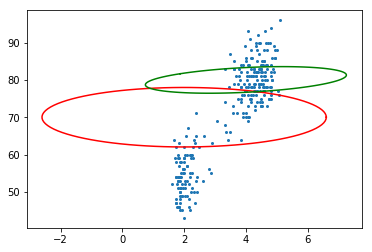

In [4]:
def plotGaussianModel2D(mu, sigma, pltopt='k'):
    if sigma.any():
        # calculate ellipse constants
        c = chi2.ppf(0.9, 2) # use confidence interval 0.9
        # get eigen vector and eigen values
        eigenValue, eigenVector = np.linalg.eig(sigma)
        # calculate points on ellipse
        t = np.linspace(0, 2*np.pi, 100) # draw 100 points
        u = [np.cos(t), np.sin(t)]
        w = c * eigenVector.dot(np.diag(np.sqrt(eigenValue)).dot(u))
        z = w.T + mu
    else:
        z = mu
    # plot ellipse by connecting sample points on curve
    plt.plot(z[:,0], z[:,1], pltopt)
    
def colorPicker(index):
    colors = 'rgbcmyk'
    return colors[np.remainder(index, len(colors))]

def gmmplot(data, gmm):
    # plot data points
    plt.scatter(data[:, 0], data[:, 1], s=4)
    # plot Gaussian model
    color = 'rgb'
    for index, model in enumerate(gmm):
        plotGaussianModel2D(model['mean'], model['covariance'], colorPicker(index))

gmmplot(data, gmm)

## Optimizing the Mixture Model with the EM Algorithm

We can then iteratively run the expectation and maximization functions to converge on the ideal set of means for our model to fit the data.  Expectation computes the posterior probabilities of class k given datapoint x, which is determined by the multivariate normal distribution. The results at intermediate steps and the final result are displayed below, and we can observe the representative elipses converging to best fit around the data.  However, only their locations can change and not their dimensions, which is the focus of the next section.  Note that rather than running for a set number of iterations, I made the algorithm run until the change in value of every dimension of every mean was very small, indicating convergence.  As can be seen, this does not take very long even with a very small tolerance for the convergence flag, so the model is very accurate.

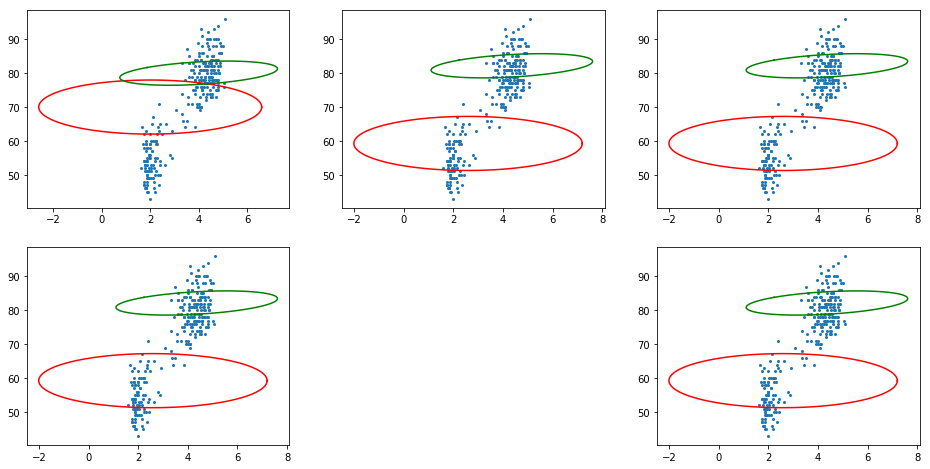

In [23]:
from gmmlib import expectation, maximization, maximization_mean

# make a true copy of our model
gmmcp = copy.deepcopy(gmm)

# create figure
plt.figure(figsize=(16, 8))
# improve model with EM-Algorithm
converged = False
i = 0
while(not converged):
    means = [gmmcp[k]['mean'] for k in range(len(gmmcp))]
    # plot current status
    plt.subplot(231 + i)
    gmmplot(data, gmmcp)
    # excute EM-Algorithm
    for j in range(5):
        posterior = expectation(data, gmmcp)
        gmmcp = maximization_mean(posterior, data, gmmcp)
    converged = True
    for k in range(len(gmmcp)):
        for j in range(len(gmmcp[k]['mean'])):
            if abs(means[k][j] - gmmcp[k]['mean'][j]) >.000000000001:
                converged = False
                break
    i+= 1
# plot final status
plt.subplot(236)
gmmplot(data,gmmcp)